# Pytorch Geometric GNN - homogen

## Import section

In [1]:
from utils.data_related.data_gen import data_transform_split

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
from sklearn.metrics import roc_auc_score

In [3]:
from torch_geometric.transforms import GCNNorm, NormalizeFeatures

## Section for GNN with rdkit

In [4]:
data_rdkit, id_breakpoint = data_transform_split(2)

D:\DATEN\Bachelorarbeit\utils\data_related\data_gen.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id_1'] = df['aid'].map(lambda x: aid_translation_dictionary[x])
D:\DATEN\Bachelorarbeit\utils\data_related\data_gen.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id_2'] = df['cid'].map(lambda x: cid_translation_dictionary[x])
D:\DATEN\Bachelorarbeit\utils\data_related\data_gen.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [5]:
data_rdkit

Data(x=[457560, 205], train_pos_edge_index=[2, 979616], train_neg_edge_index=[2, 65612424], test_pos_edge_index=[2, 244898], test_neg_edge_index=[2, 16403118])

In [6]:
data_rdkit.num_features

205

In [7]:
data_rdkit.x

tensor([[0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.8007],
        [0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.7215],
        [0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.8188],
        ...,
        [0.5812, 0.5548, 0.5812,  ..., 0.0000, 0.0000, 0.4000],
        [0.6639, 0.7143, 0.6639,  ..., 0.0000, 0.0000, 0.5495],
        [0.6010, 0.5109, 0.6010,  ..., 0.0000, 0.0000, 0.9654]])

In [8]:
data_rdkit.x.shape[0]

457560

## Setup pytorch Model

In [9]:
class GNN_homogen_with_data(torch.nn.Module):
    '''
    basic implementation of GNN, inspired by content shown in https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post12.html from Antionio Longa
    '''
    def __init__(self):
        super(GNN_homogen_with_data, self).__init__()
        self.conv1 = GCNConv(data.num_features, int(data.num_features/2))
        self.conv2 = GCNConv(int(data.num_features/2), 64)
    
    def encode(self):
        x = self.conv1(data.x.relu(), data.train_pos_edge_index) # first convolution layer
        x = x.relu() # relu function for tu - disables negative values
        x = self.conv2(x, data.train_pos_edge_index) # second convolution layer
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) #fuse pos and neg edges together
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1) # dot product of ... getting the mapped entries with z? z=model?
        return logits
    
    def decode_all(self, z):
        prob_adj = z @ z.t() # get adjacenticy matrix NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list # should this not be 0.5?

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
data = data_rdkit.to(device)
model = GNN_homogen_with_data().to(device)
optimizer = torch.optim.Adam(params=model.parameters())#, lr=0.01)

In [12]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

## Manual execution of Training

In [17]:
model.train()

GNN_homogen_with_data(
  (conv1): GCNConv(205, 102)
  (conv2): GCNConv(102, 64)
)

In [18]:
optimizer.zero_grad()

In [19]:
z=model.encode()

In [20]:
z

tensor([[-0.6108, -0.2757, -0.5796,  ..., -0.3224,  0.2393,  0.6543],
        [-0.2517, -0.0672, -0.2084,  ..., -0.1059,  0.0637,  0.2255],
        [-0.1753, -0.0630, -0.1603,  ..., -0.0789, -0.0026,  0.1216],
        ...,
        [-0.0982,  0.0279, -0.1742,  ..., -0.1223,  0.0481,  0.3290],
        [ 0.0032,  0.0266, -0.2157,  ..., -0.2362, -0.0339,  0.2686],
        [-0.1065, -0.0011, -0.1270,  ..., -0.1782,  0.0692,  0.3478]],
       grad_fn=<AddBackward0>)

In [22]:
link_logits = model.decode(z, data.train_pos_edge_index, data.train_neg_edge_index)
link_logits

tensor([71.3877, 26.8403, 60.4737,  ...,  6.1970,  1.0759,  3.0830],
       grad_fn=<SumBackward1>)

In [26]:
link_labels = get_link_labels(data.train_pos_edge_index, data.train_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [27]:
loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
loss

tensor(6.4775, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [28]:
loss.backward()

In [29]:
optimizer.step()

## Setup automatic training and testing

In [16]:
from utils.accuracy.accuracy_recommender import calc_ROC_curve, accuracy_precision_recall

In [13]:
def train():
    model.train()
    optimizer.zero_grad()
    link_logits = model.decode(model.encode(), data.train_pos_edge_index, data.train_neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, data.train_neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss

In [14]:
@torch.no_grad()
def test():
    model.eval()
    link_probs = model.decode(model.encode(), data.test_pos_edge_index, data.test_neg_edge_index).sigmoid()
    link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
    return roc_auc_score(link_labels.cpu(), link_probs.cpu())

In [20]:
@torch.no_grad()
def full_test():
    model.eval()
    link_logits = model.decode(model.encode(), data.test_pos_edge_index, data.test_neg_edge_index)
    print(link_logits)
    link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
    # compute recall and precision
    precision, recall = accuracy_precision_recall(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                  link_labels, link_logits)
    print("precision:", precision, "\nrecall:", recall)
    # plot ROC CURVE
    calc_ROC_curve(link_labels, link_logits)

## Do epoch range training and testing

In [18]:
for epoch in range(1, 11):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 1 ; Loss: tensor(8.1648, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.734894487055063
Epoch: 2 ; Loss: tensor(5.9394, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7403074671613384
Epoch: 3 ; Loss: tensor(4.2368, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7406186214206595
Epoch: 4 ; Loss: tensor(2.9826, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7413440350587637
Epoch: 5 ; Loss: tensor(2.1156, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7430194773936659
Epoch: 6 ; Loss: tensor(1.5609, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7457849213787071
Epoch: 7 ; Loss: tensor(1.2345, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7488972963952266
Epoch: 8 ; Loss: tensor(1.0644, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7507058799598634
Epoch: 9 ; Loss: tensor(0.9934, grad_fn=<BinaryCrossEntropyWithLogitsBack

tensor([ 0.7485,  1.2444,  0.1778,  ...,  1.1493,  0.0380, -0.0166])
precision: 0.34114521376116075 
recall: 0.5606963522565277


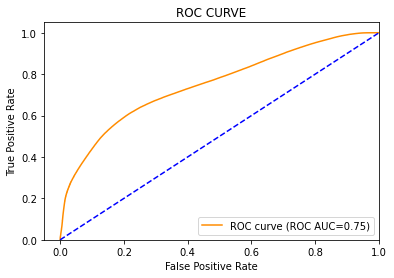

In [21]:
full_test()

In [22]:
for epoch in range(11, 21):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 11 ; Loss: tensor(0.9852, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7491760732374726
Epoch: 12 ; Loss: tensor(0.9941, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7490796706371698
Epoch: 13 ; Loss: tensor(0.9951, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7496266871771983
Epoch: 14 ; Loss: tensor(0.9842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.75081643175045
Epoch: 15 ; Loss: tensor(0.9616, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7524629560717904
Epoch: 16 ; Loss: tensor(0.9297, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7543032851499354
Epoch: 17 ; Loss: tensor(0.8929, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.756329610630625
Epoch: 18 ; Loss: tensor(0.8555, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.758859520386792
Epoch: 19 ; Loss: tensor(0.8203, grad_fn=<BinaryCrossEntropyWithLogi

tensor([ 0.1431,  0.4827,  0.0524,  ...,  0.4116, -0.0037, -0.0678])
precision: 0.3401326042232718 
recall: 0.5127571145420337


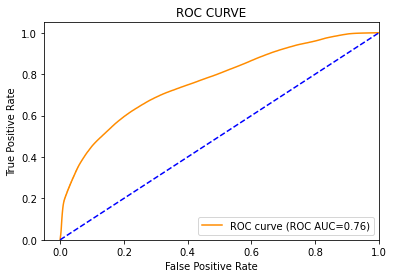

In [23]:
full_test()

In [24]:
for epoch in range(21, 30):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 21 ; Loss: tensor(0.7615, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7620424279505389
Epoch: 22 ; Loss: tensor(0.7400, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.758522597502523
Epoch: 23 ; Loss: tensor(0.7237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7508692832489584
Epoch: 24 ; Loss: tensor(0.7116, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.73882284608682
Epoch: 25 ; Loss: tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7245556010186602
Epoch: 26 ; Loss: tensor(0.6969, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7109844685326682
Epoch: 27 ; Loss: tensor(0.6927, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.6988168559266055
Epoch: 28 ; Loss: tensor(0.6898, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.6882277568853056
Epoch: 29 ; Loss: tensor(0.6877, grad_fn=<BinaryCrossEntropyWithLog

tensor([-0.1402,  0.1175, -0.0310,  ...,  0.0731, -0.0336, -0.0700])
precision: 0.27848542105968777 
recall: 0.24804598554035698


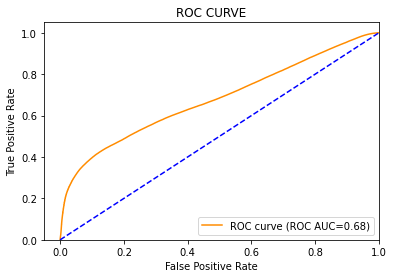

In [25]:
full_test()

## Alternative Model using bilinear layer instead of dotproduct for decode

In [13]:
from torch.nn import Bilinear, Flatten

In [14]:
class GNN_homogen_with_data_bil(torch.nn.Module):
    '''
    basic implementation of GNN, inspired by content shown in https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post12.html from Antionio Longa
    '''
    def __init__(self):
        super(GNN_homogen_with_data_bil, self).__init__()
        self.conv1 = GCNConv(data.num_features, int(data.num_features/2))
        self.conv2 = GCNConv(int(data.num_features/2), 64)
        self.bilin = Bilinear(64, 64, 1)
        self.endflat = Flatten(0,-1)
    
    def encode(self):
        x = self.conv1(data.x.relu(), data.train_pos_edge_index) # first convolution layer
        x = x.relu() # relu function for tu - disables negative values
        x = self.conv2(x, data.train_pos_edge_index) # second convolution layer
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) #fuse pos and neg edges together
        logits = self.endflat(self.bilin(z[edge_index[0]], z[edge_index[1]]))
        return logits

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
data = data_rdkit.to(device)
model = GNN_homogen_with_data_bil().to(device)
optimizer = torch.optim.Adam(params=model.parameters())#, lr=0.01)

In [17]:
for epoch in range(1, 6):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1091043983360 bytes.

## Beginning of accuracy section

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

In [8]:
def calc_and_plot_ROC_pyg(link_labels, link_logits):
    label_prob = link_logits.sigmoid()
    # use sklearn to get fpr and tpr
    fpr, tpr, _ = metrics.roc_curve(link_labels.detach().numpy(), label_prob.detach().numpy())
    # calculate the roc_auc (area under the curve)
    roc_auc = metrics.auc(fpr, tpr)
    # PLOT THE ROC CURVE
    '''
    Following code inspired/partly copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    '''
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", label="ROC curve (ROC AUC=%0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color="blue", linestyle="--")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC CURVE")
    plt.legend(loc="lower right")
    plt.show()

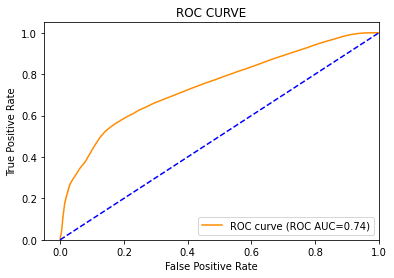

In [74]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [23]:
def accuracy_precision_recall_pyg(edge_index, link_labels, link_logits, id_breakpoint):
    # define function for creating precision and recall at k for each user
    def precision_recall_at_k(edge_index, link_labels, link_logits, k, threshold, id_breakpoint):
        # problem with duplicity of edges... fixed with double of simplelib k, then it should result in the same metrics
        user_est_true = defaultdict(list)
        # write user_est_true
        for edge, true_label, pred_label in zip(edge_index.t().detach().numpy(), link_labels.detach().numpy(), link_logits.sigmoid().detach().numpy()):
            user = None
            # determine user. user = experiment
            if edge[0]<id_breakpoint:
                user = edge[0]
            else:
                user = edge[1]
            # write into user_est_true
            user_est_true[user].append((pred_label, true_label))

        # create precisions and recalls dictionary
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls
    # execute precision-recall function and compute average over precision and recall values
    precision_list, recall_list = precision_recall_at_k(edge_index, link_labels, link_logits, 200, 0.5, id_breakpoint)
    p = sum(precision_list.values())/len(precision_list)
    r = sum(recall_list.values())/len(recall_list)
    return p, r

In [ ]:
threshold = 0.9
k=100

In [89]:
precisions = {}
recalls = {}
for id, content in group:
    c = content.sort_values(by=['pred_label'], ascending=False)
    n_rel = (c.true_label>=threshold).sum()
    n_rec_k = (c.pred_label[:k] >= threshold).sum()
    n_rel_and_rec_k = ((c.true_label[:k]>=threshold) & (c.pred_label[:k]>=threshold)).sum()
    precisions[id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
    recalls[id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [91]:
prec = sum(p for p in precisions.values()) / len(precisions)
rec = sum(r for r in recalls.values()) / len(recalls)
print(prec, rec)

0.19186817882835175 0.04098766290762394


In [89]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.train_pos_edge_index, data.train_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)

In [90]:
print("precision:", precision, "\nrecall:", recall)

precision: 0.36884013842343405 
recall: 0.6119862432430785


## Testing it with test data - worst test case (manual testing section)

In [126]:
model.eval()

GNN_homogen_with_data(
  (conv1): GCNConv(205, 102)
  (conv2): GCNConv(102, 64)
)

In [127]:
z = model.encode()

In [128]:
z

tensor([[-0.0330, -0.0004,  0.0117,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        ...,
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610]],
       grad_fn=<AddBackward0>)

In [129]:
link_logits = model.decode(z, data.test_pos_edge_index, data.test_neg_edge_index)
link_logits

tensor([0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
       grad_fn=<SumBackward1>)

In [130]:
link_probs = link_logits.sigmoid()
link_probs

tensor([0.5093, 0.5092, 0.5092,  ..., 0.5092, 0.5092, 0.5092],
       grad_fn=<SigmoidBackward0>)

In [137]:
link_logits[0]

tensor(0.0370, grad_fn=<SelectBackward0>)

In [131]:
(link_probs<0.5).sum()

tensor(0)

In [132]:
link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

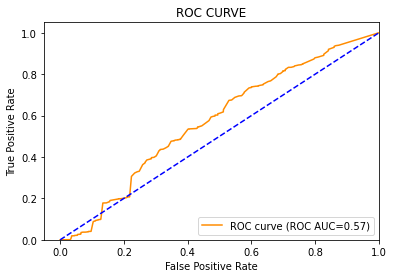

In [133]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [134]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)

In [135]:
print("precision:", precision, "\nrecall:", recall)

precision: 0.3608354276867442 
recall: 0.6721041255977497


## Test section 2

In [218]:
model.eval()
z=model.encode()
z

tensor([[-0.1414, -0.1699, -0.0718,  ..., -0.0716, -0.1209, -0.1339],
        [-0.0779, -0.0596, -0.0362,  ..., -0.0012, -0.0550, -0.0735],
        [-0.0961, -0.0153,  0.0493,  ..., -0.0115,  0.0200, -0.0973],
        ...,
        [-0.0266, -0.0262, -0.0494,  ..., -0.0315, -0.0786,  0.0398],
        [ 0.0965,  0.0257, -0.0892,  ..., -0.0850, -0.0207,  0.1184],
        [-0.0029, -0.0178, -0.0322,  ..., -0.0350, -0.0455,  0.0485]],
       grad_fn=<AddBackward0>)

In [219]:
link_logits = model.decode(z, data.test_pos_edge_index, data.test_neg_edge_index)
link_logits.sigmoid()

tensor([0.6867, 0.7601, 0.5345,  ..., 0.7459, 0.5091, 0.5096],
       grad_fn=<SigmoidBackward0>)

In [223]:
(link_logits.sigmoid()<0.5).sum()

tensor(510480)

In [220]:
link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

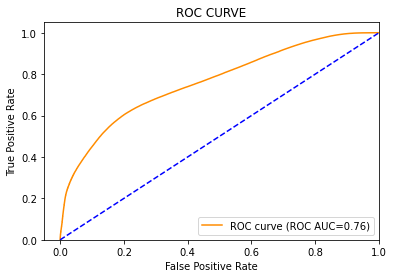

In [221]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [222]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)
print("precision:", precision, "\nrecall:", recall)

precision: 0.34207395758778514 
recall: 0.6056583577358485
